In [1]:
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm, TwoSlopeNorm
from pathlib import Path
from tqdm import tqdm
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import seaborn as sns
import yaml
import pickle

from convml_tt.data.dataset import TRIPLET_TILE_FILENAME_FORMAT

import convml_tt.interpretation.plots

import convml_tt.interpretation.embedding_transforms

from convml_tt.interpretation.plots import isomap2d
from convml_tt.interpretation.plots import manifold2d

from convml_tt.data.transforms import get_transforms
from convml_tt.interpretation.embedding_transforms import apply_transform

In [2]:
folder_1k = "Aqua1kmNorthAt2022"
folder_Hk = "AquaHkmNorthAt2022"

#folder = "AquaHkmLabSea2022b"
#folder = "Aqua1kmLabSea2022"

directory = "/home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/"
#filepath = directory + folder

filename = "embs.nc"
#filename = "embs_no_land.nc"
#filename = "embs_no_ice.nc" # This data also has no land
#filename = "embs_cao.nc"

In [49]:
rng = np.random.default_rng(42)

In [4]:
tiles_ds_1k = xr.open_dataset(directory+folder_1k+"/"+filename)
tiles_ds_1k = tiles_ds_1k.drop(['cao','siconc', 'isomap_coords'])
tiles_ds_1k = tiles_ds_1k.assign_coords(resolution='1km')
tiles_ds_1k

<xarray.Dataset>
Dimensions:        (tile_id: 10000, tile_type: 3, emb_dim: 100)
Coordinates:
  * tile_id        (tile_id) int64 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
  * tile_type      (tile_type) object 'anchor' 'neighbor' 'distant'
    resolution     <U3 '1km'
Dimensions without coordinates: emb_dim
Data variables:
    embs           (tile_type, tile_id, emb_dim) float32 ...
    c_lat          (tile_type, tile_id) float32 ...
    c_lon          (tile_type, tile_id) float32 ...
    time           (tile_type, tile_id) datetime64[ns] ...
    land_fraction  (tile_type, tile_id) float32 ...

In [5]:
tiles_ds_Hk = xr.open_dataset(directory+folder_Hk+"/"+filename)
tiles_ds_Hk = tiles_ds_Hk.drop(['isomap_coords'])
tiles_ds_Hk = tiles_ds_Hk.assign_coords(resolution='Hkm')
#tiles_ds_Hk = tiles_ds_Hk.assign_coords(tile_id=tiles_ds_Hk.tile_id + 10000)
tiles_ds_Hk

<xarray.Dataset>
Dimensions:        (tile_id: 10000, tile_type: 3, emb_dim: 100)
Coordinates:
  * tile_id        (tile_id) int64 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
  * tile_type      (tile_type) object 'anchor' 'neighbor' 'distant'
    resolution     <U3 'Hkm'
Dimensions without coordinates: emb_dim
Data variables:
    embs           (tile_type, tile_id, emb_dim) float32 ...
    c_lat          (tile_type, tile_id) float32 ...
    c_lon          (tile_type, tile_id) float32 ...
    time           (tile_type, tile_id) datetime64[ns] ...
    land_fraction  (tile_type, tile_id) float32 ...

In [6]:
# Combine two sets of embeddings

tiles_ds = xr.concat([tiles_ds_1k, tiles_ds_Hk], dim='resolution')
#tiles_ds = xr.concat([tiles_ds_1k, tiles_ds_Hk], dim='tile_id')
tiles_ds

<xarray.Dataset>
Dimensions:        (tile_id: 10000, tile_type: 3, resolution: 2, emb_dim: 100)
Coordinates:
  * tile_id        (tile_id) int64 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
  * tile_type      (tile_type) object 'anchor' 'neighbor' 'distant'
  * resolution     (resolution) <U3 '1km' 'Hkm'
Dimensions without coordinates: emb_dim
Data variables:
    embs           (resolution, tile_type, tile_id, emb_dim) float32 0.05868 ...
    c_lat          (resolution, tile_type, tile_id) float32 45.93 ... 48.22
    c_lon          (resolution, tile_type, tile_id) float32 -30.05 ... -40.22
    time           (resolution, tile_type, tile_id) datetime64[ns] 2022-05-25...
    land_fraction  (resolution, tile_type, tile_id) float32 0.0 0.0 ... 0.0 0.0

In [7]:
# get isomap coordinates for each embedding and add to ds
isomap_coords, isomap_model = apply_transform(da=tiles_ds.embs[:,:,0:5000], transform_type="isomap", return_model=True)
tiles_ds['isomap_coords'] = isomap_coords

/home/eefjg/miniconda3/envs/convml-tt/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/eefjg/miniconda3/envs/convml-tt/lib/python3.11/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [12]:
tiles_ds['isomap_coords'] = isomap_coords
tiles_ds

<xarray.Dataset>
Dimensions:        (tile_id: 10000, tile_type: 3, resolution: 2, emb_dim: 100,
                    isomap_dim: 2)
Coordinates:
  * tile_id        (tile_id) int64 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
  * tile_type      (tile_type) object 'anchor' 'neighbor' 'distant'
  * resolution     (resolution) <U3 '1km' 'Hkm'
Dimensions without coordinates: emb_dim, isomap_dim
Data variables:
    embs           (resolution, tile_type, tile_id, emb_dim) float32 0.05868 ...
    c_lat          (resolution, tile_type, tile_id) float32 45.93 ... 48.22
    c_lon          (resolution, tile_type, tile_id) float32 -30.05 ... -40.22
    time           (resolution, tile_type, tile_id) datetime64[ns] 2022-05-25...
    land_fraction  (resolution, tile_type, tile_id) float32 0.0 0.0 ... 0.0 0.0
    isomap_coords  (isomap_dim, resolution, tile_type, tile_id) float32 -0.13...

In [9]:
isomap_coords_part2 = apply_transform(da=tiles_ds.embs[:,:,5000:], transform_type="isomap", pretrained_model=isomap_model)

In [15]:
isomap_coords_part2

<xarray.DataArray 'emb' (isomap_dim: 2, resolution: 2, tile_type: 3,
                         tile_id: 5000)>
array([[[[ 0.75394905, -0.27173114, -1.0978806 , ..., -1.2372525 ,
          -1.1099705 ,  0.8700958 ],
         [ 0.49497986, -0.3527678 , -1.1382338 , ..., -0.8278794 ,
          -1.2118514 ,  0.6165183 ],
         [-0.8270967 ,  0.8836891 , -1.1701127 , ..., -0.05815838,
           0.54826295, -1.0295424 ]],

        [[ 0.7603674 , -0.27176034, -1.0900623 , ..., -1.2377342 ,
          -1.1107793 ,  0.86888915],
         [ 0.57526314, -0.34883288, -1.1391739 , ..., -0.8275751 ,
          -1.211754  ,  0.579492  ],
         [-0.8263351 ,  0.9827392 , -1.1701273 , ..., -0.01173051,
           0.54639786, -1.029552  ]]],


       [[[ 0.8750811 ,  0.00948471,  0.01426383, ..., -0.16762629,
          -0.18736714,  0.36291894],
         [ 0.35360155, -0.0051285 , -0.06541966, ..., -0.10420503,
          -0.2022109 ,  0.30622265],
         [ 0.12084096,  0.9914935 , -0.12850069, ..., -0.00751247,
           0.32153162,  0.04512754]],

        [[ 0.86203045,  0.01008172, -0.0080508 , ..., -0.16769233,
          -0.18749806,  0.4131731 ],
         [ 0.46457198, -0.00737848, -0.06956184, ..., -0.10407152,
          -0.20220873,  0.3424929 ],
         [ 0.12089856,  1.0558391 , -0.12850206, ...,  0.0081594 ,
           0.44840184,  0.04541532]]]], dtype=float32)
Coordinates:
  * resolution  (resolution) object '1km' 'Hkm'
  * tile_type   (tile_type) object 'anchor' 'neighbor' 'distant'
  * tile_id     (tile_id) int64 5000 5001 5002 5003 5004 ... 9996 9997 9998 9999
Dimensions without coordinates: isomap_dim
Attributes:
    tile_type:       ANCHOR
    data_dir:        /home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/Aqua1kmNorthAt...
    stage:           
    transform_type:  isomap

In [18]:
tiles_ds['isomap_coords'][:,:,:,5000:] 

<xarray.DataArray 'isomap_coords' (isomap_dim: 2, resolution: 2, tile_type: 3,
                                   tile_id: 5000)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * tile_id     (tile_id) int64 5000 5001 5002 5003 5004 ... 9996 9997 9998 9999
  * tile_type   (tile_type) object 'anchor' 'neighbor' 'distant'
  * resolution  (resolution) <U3 '1km' 'Hkm'
Dimensions without coordinates: isomap_dim
Attributes:
    tile_type:       ANCHOR
    data_dir:        /home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/Aqua1kmNorthAt...
    stage:           
    transform_type:  isomap

In [19]:
tiles_ds['isomap_coords'][:,:,:,5000:] = isomap_coords_part2

In [20]:
tiles_ds

<xarray.Dataset>
Dimensions:        (tile_id: 10000, tile_type: 3, resolution: 2, emb_dim: 100,
                    isomap_dim: 2)
Coordinates:
  * tile_id        (tile_id) int64 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
  * tile_type      (tile_type) object 'anchor' 'neighbor' 'distant'
  * resolution     (resolution) <U3 '1km' 'Hkm'
Dimensions without coordinates: emb_dim, isomap_dim
Data variables:
    embs           (resolution, tile_type, tile_id, emb_dim) float32 0.05868 ...
    c_lat          (resolution, tile_type, tile_id) float32 45.93 ... 48.22
    c_lon          (resolution, tile_type, tile_id) float32 -30.05 ... -40.22
    time           (resolution, tile_type, tile_id) datetime64[ns] 2022-05-25...
    land_fraction  (resolution, tile_type, tile_id) float32 0.0 0.0 ... 0.0 0.0
    isomap_coords  (isomap_dim, resolution, tile_type, tile_id) float32 -0.13...

In [21]:
tiles_ds.to_netcdf(directory+"all_embs.nc")

In [23]:
pickle.dump(isomap_model, open(directory+"isomap_model.pkl", "wb"))

##### Open saved datasets

In [3]:
tiles_ds = xr.open_dataset(directory+"all_embs.nc")

In [9]:
da2 = tiles_ds.isomap_coords.rename(tile_id="ixy")
da2

<xarray.DataArray 'isomap_coords' (isomap_dim: 2, resolution: 2, tile_type: 3,
                                   ixy: 10000)>
[120000 values with dtype=float32]
Coordinates:
  * ixy         (ixy) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * tile_type   (tile_type) object 'anchor' 'neighbor' 'distant'
  * resolution  (resolution) object '1km' 'Hkm'
Dimensions without coordinates: isomap_dim
Attributes:
    tile_type:       ANCHOR
    data_dir:        /home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/Aqua1kmNorthAt...
    stage:           
    transform_type:  isomap

In [15]:

lxy=3.0
n_min=16
N=16
px=32
pt_c=[0.0, 0.0]

Nx = Ny = N
lx = ly = lxy
dx = lx / Nx
dy = ly / Ny

da_x = da2.sel(isomap_dim=0)
da_y = da2.sel(isomap_dim=1)

xmin = pt_c[0] - lx / 2.0
xmax = pt_c[0] + lx / 2.0
ymin = pt_c[1] - ly / 2.0
ymax = pt_c[1] + ly / 2.0

da_ix = ((da_x - xmin) / dx).astype(int)
da_iy = ((da_y - ymin) / dy).astype(int)

xlim = xmin, xmax
ylim = ymin, ymax

da2.coords["ix"] = da_ix
da2.coords["iy"] = da_iy
da2.coords["tile_id"] = da2.ixy

In [19]:
da_ix

<xarray.DataArray 'isomap_coords' (resolution: 2, tile_type: 3, ixy: 10000)>
array([[[ 7,  4,  7, ...,  1,  2, 12],
        [ 6,  5,  8, ...,  3,  1, 11],
        [ 2,  8, 15, ...,  7, 10,  2]],

       [[ 7,  4,  7, ...,  1,  2, 12],
        [ 6,  5,  7, ...,  3,  1, 11],
        [ 2,  8, 15, ...,  7, 10,  2]]])
Coordinates:
  * ixy         (ixy) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * tile_type   (tile_type) object 'anchor' 'neighbor' 'distant'
  * resolution  (resolution) object '1km' 'Hkm'

In [16]:
da2

<xarray.DataArray 'isomap_coords' (isomap_dim: 2, resolution: 2, tile_type: 3,
                                   ixy: 10000)>
[120000 values with dtype=float32]
Coordinates:
  * ixy         (ixy) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * tile_type   (tile_type) object 'anchor' 'neighbor' 'distant'
  * resolution  (resolution) object '1km' 'Hkm'
    ix          (resolution, tile_type, ixy) int64 7 4 7 8 1 9 ... 1 12 2 7 10 2
    iy          (resolution, tile_type, ixy) int64 8 8 7 7 7 5 ... 8 12 7 8 10 8
    tile_id     (ixy) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
Dimensions without coordinates: isomap_dim
Attributes:
    tile_type:       ANCHOR
    data_dir:        /home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/Aqua1kmNorthAt...
    stage:           
    transform_type:  isomap

In [23]:
da2[:,0,0,:] 

<xarray.DataArray 'isomap_coords' (isomap_dim: 2, ixy: 10000)>
[20000 values with dtype=float32]
Coordinates:
  * ixy         (ixy) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
    tile_type   <U6 'anchor'
    resolution  <U3 '1km'
    ix          (ixy) int64 7 4 7 8 1 9 3 8 2 15 ... 12 15 9 13 11 11 7 1 2 12
    iy          (ixy) int64 8 8 7 7 7 5 8 9 8 3 9 8 ... 8 12 4 9 7 5 12 6 7 7 9
    tile_id     (ixy) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
Dimensions without coordinates: isomap_dim
Attributes:
    tile_type:       ANCHOR
    data_dir:        /home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/Aqua1kmNorthAt...
    stage:           
    transform_type:  isomap

In [25]:
da2= da2[:,0,0,:].set_index(ixy=("ix", "iy"))

In [26]:
da2

<xarray.DataArray 'isomap_coords' (isomap_dim: 2, ixy: 10000)>
[20000 values with dtype=float32]
Coordinates:
    tile_type   <U6 'anchor'
    resolution  <U3 '1km'
    tile_id     (ixy) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * ixy         (ixy) object MultiIndex
  * ix          (ixy) int64 7 4 7 8 1 9 3 8 2 15 ... 12 15 9 13 11 11 7 1 2 12
  * iy          (ixy) int64 8 8 7 7 7 5 8 9 8 3 9 8 ... 8 12 4 9 7 5 12 6 7 7 9
Dimensions without coordinates: isomap_dim
Attributes:
    tile_type:       ANCHOR
    data_dir:        /home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/Aqua1kmNorthAt...
    stage:           
    transform_type:  isomap

In [10]:
tiles_ds.isomap_coords.coords

Coordinates:
  * tile_id     (tile_id) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * tile_type   (tile_type) object 'anchor' 'neighbor' 'distant'
  * resolution  (resolution) object '1km' 'Hkm'

In [4]:
isomap_model = pickle.load(open(directory+"isomap_model.pkl", "rb"))

In [39]:

tiles_ds.embs

<xarray.DataArray 'embs' (resolution: 2, tile_type: 3, tile_id: 10000,
                          emb_dim: 100)>
[6000000 values with dtype=float32]
Coordinates:
  * tile_id     (tile_id) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * tile_type   (tile_type) object 'anchor' 'neighbor' 'distant'
  * resolution  (resolution) object '1km' 'Hkm'
Dimensions without coordinates: emb_dim
Attributes:
    tile_type:  ANCHOR
    data_dir:   /home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/Aqua1kmNorthAt2022/...
    stage:

  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:01<00:00, 17.67it/s]


(-1.2, 1.5)

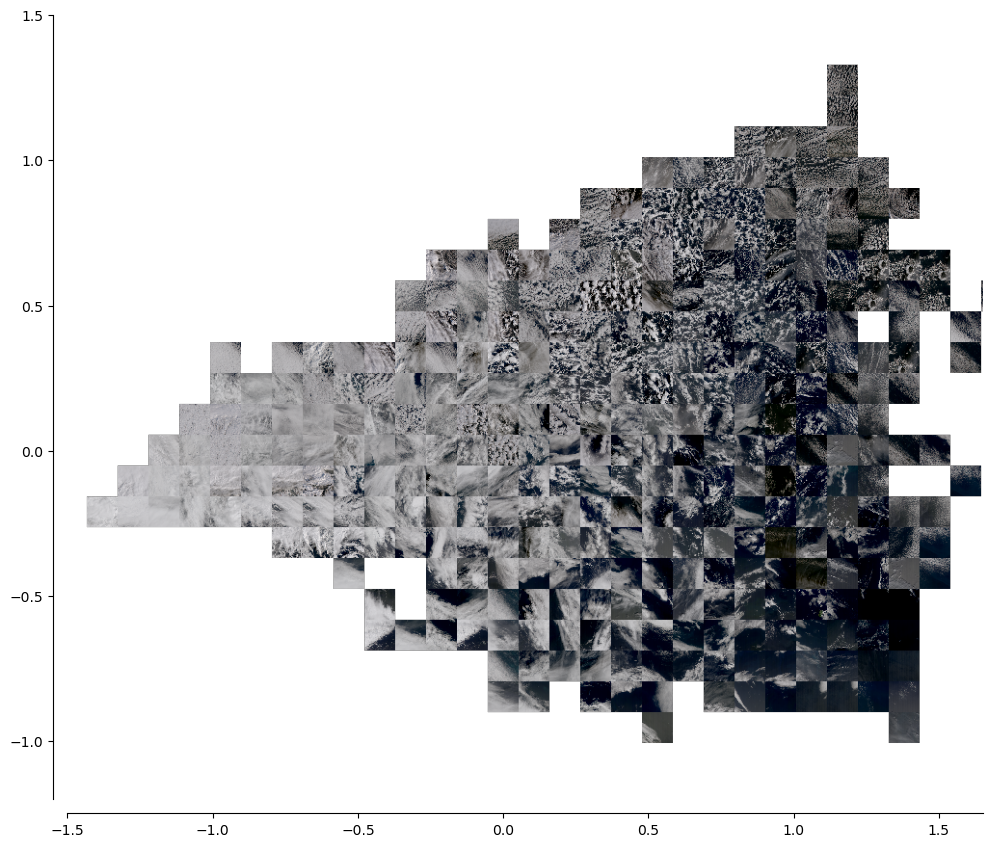

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))

plot = manifold2d.make_grid_based_manifold_plot(tiles_ds.embs[0,:,:,:], tiles_ds.isomap_coords[:,0,0,:], 
                                                ax=ax, dx=0.1, data_dir="/home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/Aqua1kmNorthAt2022/triplets")

ax.set_xlim(-1.5, None)
ax.set_ylim(-1.2, 1.5)

# pick ten random tiles and plot the isomap coordinates on the manifold
tiles = np.random.choice(tiles_ds.tile_id, 10)




100%|██████████| 34/34 [00:02<00:00, 14.83it/s]


(-1.2, 1.5)

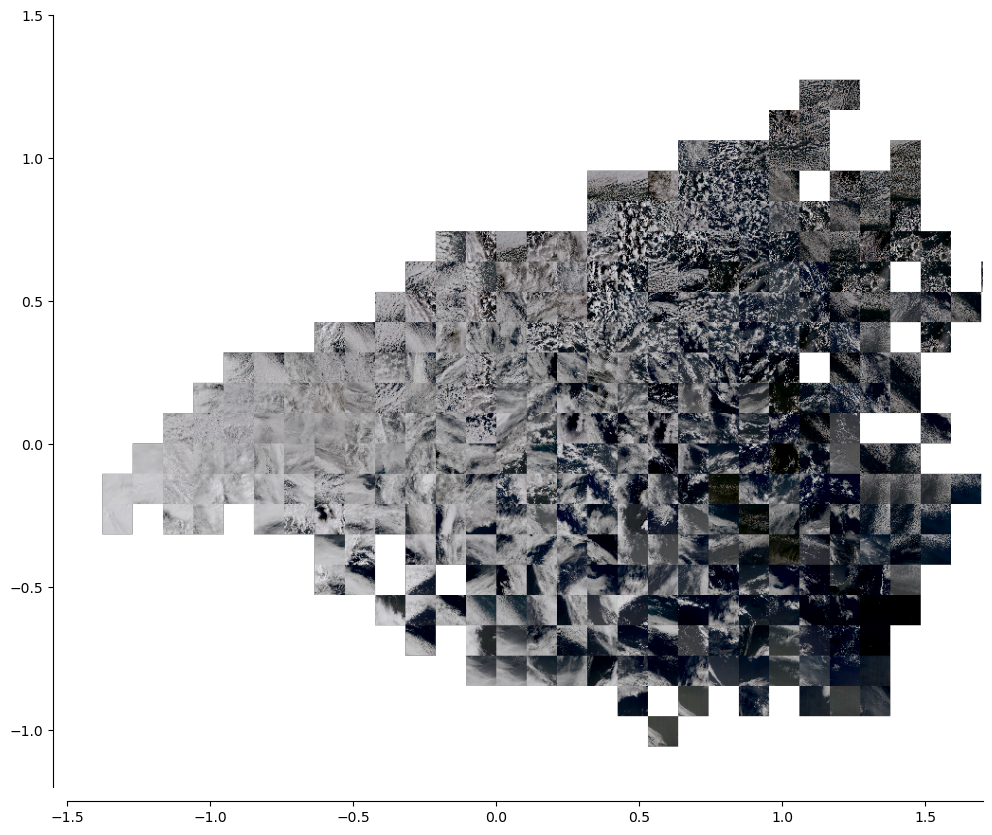

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))

plot = manifold2d.make_grid_based_manifold_plot(tiles_ds.embs[1,:,:,:], tiles_ds.isomap_coords[:,1,0,:], 
                                                ax=ax, dx=0.1, data_dir="/home/eefjg/OneDrive/Leeds/PhD/Data/MODIS/AquaHkmNorthAt2022/triplets")

ax.set_xlim(-1.5, None)
ax.set_ylim(-1.2, 1.5)